## Introduction

***Please, pay attention, that it shows the logic of training the model, but it doesn't include all needed pieces of code which is necessary to run it from top to bottom and reproduce the result.***

In [ ]:
# connect to Google Disk

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# install requirements

repo_folder = '/content/drive/MyDrive/github/'

reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

In [ ]:
# import libraries

import sys

# NNs
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertForTokenClassification

# serialization and collections
import json
import collections
from typing import List, Tuple, Callable, Dict, Set, Union
from glob import glob

## NLP
from rusenttokenize import ru_sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import wordpunct_tokenize


## visualization
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
from ipymarkup import show_span_line_markup

sns.set_theme(style="white", context="talk")
plt.style.use('default')
%matplotlib inline

In [ ]:
# set a path to utils

base_folder = repo_folder + 'Resources/'
sys.path.append(base_folder)

## Named Entity Recognition

We have a structured text to this moment and are ready to analyze it. We'll extract titles and names from the text. The task is called Named Entity Recognition (NER).

We're going to find the following entities:

*   **PER, Person**, for instance, Elvis Presley, Audrey Hepburn, David Beckham
*   **ORG, Organization**, e.g. Google, Mastercard, Oxford University

But there are many different types of the named entities:
*   **Datetime** e.g. 2006, 16:34, 2 am
*   **Location**, for example, Trafalgar Square, MoMA, Machu Picchu
*   **Masterpiece**, e.g. "Hamlet", "Mona Lisa".

# Data

In this case, we are going to use a specific dataset from the [RuNNE](https://github.com/dialogue-evaluation/RuNNE) competition. It's related to getting named entities in a few-shot mode.

The dataset includes a lot of nested entities. Even entities of the same type can be nested. It's too complex, that's why we need to simplify the task filtering entities and leaving only those that don't intersect.

## Uploading data

In [ ]:
data_path = repo_folder + "Resources/"
#!unzip -q {data_path + "RuNNE.zip"} -d {data_path}

In [ ]:
# example of ground true entities

!head -n 10 {data_path + "RuNNE/data/train/003.ann"}

T1	NATIONALITY 62 74	американцами
T2	CITY 82 89	Бишкеке
T3	DATE 117 126	5 августа
T5	ORGANIZATION 145 179	Правоохранительные органы Киргизии
T6	COUNTRY 171 179	Киргизии
T7	COUNTRY 221 224	США
T8	CITY 227 234	Бишкеке
T9	DATE 288 298	во вторник
T10	ORGANIZATION 312 315	МВД
T12	CITY 433 440	Ынтымак


In [ ]:
# example of texts

!head -n 6 {data_path + "RuNNE/data/train/003.txt"}

Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке

05/08/2008 10:35

БИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.



In [ ]:
from utils import read_annotation

train_data = read_annotation(data_path + "RuNNE/data/train", "RuNNE-Train")
valid_data = read_annotation(data_path + "RuNNE/data/dev", "RuNNE-Dev")
test_data = read_annotation(data_path + "RuNNE/data/test", "RuNNE-Test")

Read RuNNE-Train data...:   0%|          | 0/461 [00:00<?, ?it/s]

Read RuNNE-Dev data...:   0%|          | 0/323 [00:00<?, ?it/s]

Read RuNNE-Test data...:   0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
# nice representation of entities' overlapping

show_span_line_markup(*train_data[0])

## Tokenization

Tokenization is a standard text preprocessing. There are models trained for the task. We use BERT tokenizer.

### Anaysis. Number of sentences in a document


In [ ]:
from rusenttokenize import ru_sent_tokenize
import re

In [ ]:
def sentence_segmentation(
    texts: List[str], return_coords: bool = False
) -> List[List[str]]:
    sent_per_text = []
    """
    Ваш код здесь
    """
    for text in texts:
      first_segmentation = [sentence for sentence in ru_sent_tokenize(text)]
      second_segmentation = [s for sentence in first_segmentation for s in sentence.split('\n') if s]
      for sentence in second_segmentation:
        if not return_coords:
          sent_per_text.append(sentence)
          continue
        start_position = text.find(sentence)
        end_position = start_position + len(sentence)
        sent_per_text.append((start_position, end_position, sentence))
    return sent_per_text

In [ ]:
train_sents_per_doc = sentence_segmentation([text for text, _ in train_data])
valid_sents_per_doc = sentence_segmentation([text for text, _ in valid_data])
test_sents_per_doc = sentence_segmentation([text for text, _ in test_data])

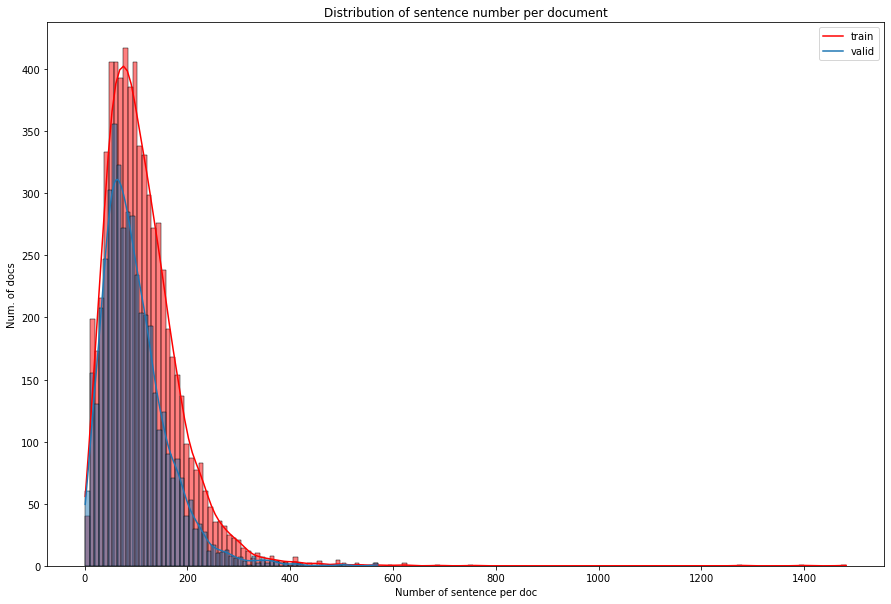

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Distribution of sentence number per document")
h = sns.histplot([len(i) for i in train_sents_per_doc], kde=True, color="red")
h = sns.histplot([len(i) for i in valid_sents_per_doc], kde=True)
h.set_ylabel("Num. of docs")
h.set_xlabel("Number of sentence per doc")
h.legend(labels=["train", "valid"])
plt.show()

How BPE tokenizer works:

In [ ]:
from transformers import BertTokenizer  # BPE токенизация

In [ ]:
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', do_lower_case=False, max_len=10000)
print("====== TOKINIZER ======")
print(tokenizer)

====== TOKINIZER ======
PreTrainedTokenizer(name_or_path='sberbank-ai/ruBert-base', vocab_size=120138, model_max_len=10000, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [ ]:
in_data = "Мама мыла раму окон от компании СберОкна"
print("====== INPUT DATA ======")
print(in_data)
print()
print("====== OUTPUT DATA ======")
print(tokenizer.tokenize("Мама мыла раму окон от компании СберОкна"))

====== INPUT DATA ======
Мама мыла раму окон от компании СберОкна

====== OUTPUT DATA ======
['Мама', 'мыла', 'раму', 'окон', 'от', 'компании', 'Сбер', '##О', '##к', '##на']


### Analysis. Number of BPE tokens in a document

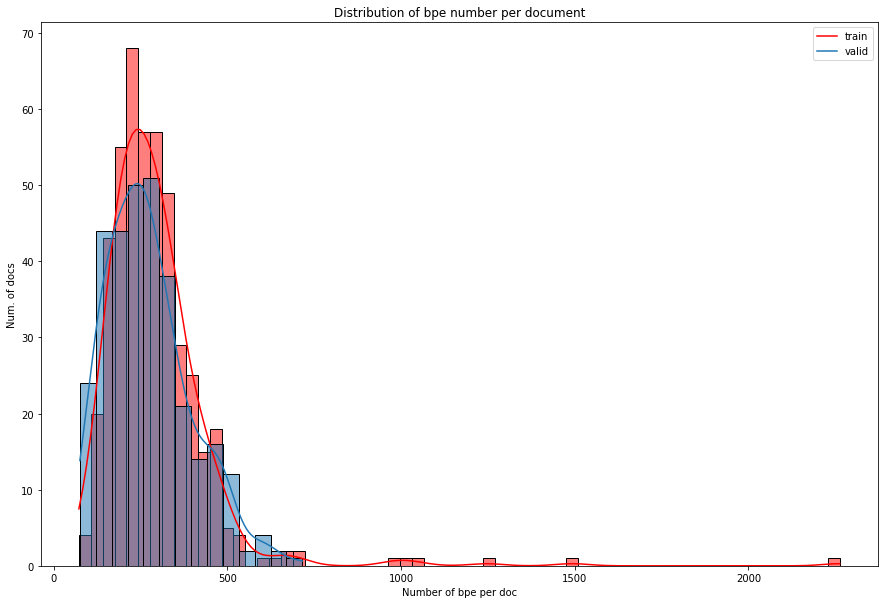

In [ ]:
train_bpe_per_docs = [tokenizer.tokenize(text) for text, _ in train_data]
valid_bpe_per_docs = [tokenizer.tokenize(text) for text, _ in valid_data]


plt.figure(figsize=(15,10))
plt.title("Distribution of bpe number per document")
h = sns.histplot([len(i) for i in train_bpe_per_docs], kde=True, color="red")
h = sns.histplot([len(i) for i in valid_bpe_per_docs], kde=True)
h.legend(labels=["train", "valid"])
h.set_ylabel("Num. of docs")
h.set_xlabel("Number of bpe per doc")
plt.show()

### Analysis. Number of BPE tokens in a sentence

In [ ]:
train_bpe_per_sentence = [tokenizer.tokenize(sentence) for sentence in train_sents_per_doc]
valid_bpe_per_sentence = [tokenizer.tokenize(sentence) for sentence in valid_sents_per_doc]
test_bpe_per_sentence = [tokenizer.tokenize(sentence) for sentence in test_sents_per_doc]

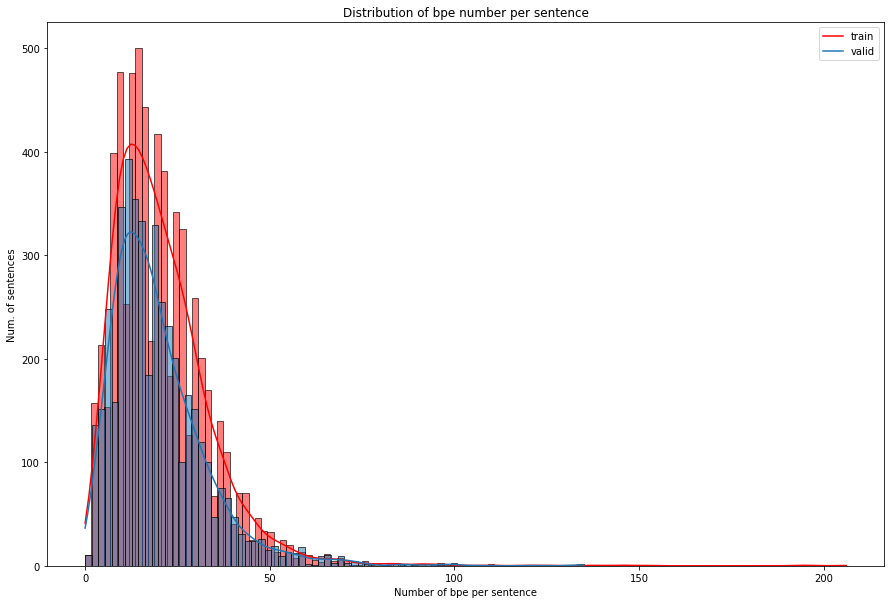

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Distribution of bpe number per sentence")
h = sns.histplot([len(i) for i in train_bpe_per_sentence], kde=True, color="red")
h = sns.histplot([len(i) for i in valid_bpe_per_sentence], kde=True)
h.legend(labels=["train", "valid"])
h.set_ylabel("Num. of sentences")
h.set_xlabel("Number of bpe per sentence")
plt.show()

It seems that token distribution is less shifted between train and validation sets in comparison with the sentence distribution.

### Analysis of markup

Let's look, how many unique "texts" (sets of symbols) are related to entities:

`set(train_entities)/list(train_entities)`.




In [ ]:
def unique_entity_texts(dataset: List[Tuple[str, List[Tuple[int, int, str]]]]):
    ent_texts = []
    """
    Ваш код здесь
    """
    for text, entities in dataset:
      for entity_start, entity_end, entity_type in entities:
        ent_texts.append(text[entity_start:entity_end])
    unique_ent_texts = set(ent_texts)
    print(f"Entities in dataset: {len(ent_texts)}")
    print(f"Unique entity texts in dataset: {len(unique_ent_texts)}")
    print(f"Relation unique ent texts to all ent texts: {round(len(unique_ent_texts) / len(ent_texts), 3)}")
    return unique_ent_texts, ent_texts # изменить

In [ ]:
print("Train data")
unique_ent_texts_train, _ = unique_entity_texts(train_data)
print("\nValid data")
unique_ent_texts_valid, _ = unique_entity_texts(valid_data)
print("\nTest data")
unique_ent_texts_test, _ = unique_entity_texts(test_data)

Train data
Entities in dataset: 27743
Unique entity texts in dataset: 15831
Relation unique ent texts to all ent texts: 0.571

Valid data
Entities in dataset: 5594
Unique entity texts in dataset: 3908
Relation unique ent texts to all ent texts: 0.699

Test data
Entities in dataset: 5843
Unique entity texts in dataset: 4036
Relation unique ent texts to all ent texts: 0.691


How many unique "texts" of entities exist in validation / test set but don't occur at the train set.

In [ ]:
def iou(
    first_set: Set[str],
    second_set: Set[str]
    ):
    """
    Ваш код здесь
    """
    return len(first_set & second_set) / len(first_set | second_set), first_set & second_set

def general_iou(
    unique_ent_texts_train: Set[str],
    unique_ent_texts_valid: Set[str],
    unique_ent_texts_test: Set[str]
    ):
    """
    Ваш код здесь
    """
    val_train_share, val_train_intersection = iou(unique_ent_texts_train, unique_ent_texts_valid)
    test_train_share, test_train_intersection = iou(unique_ent_texts_train, unique_ent_texts_test)
    return round(val_train_share, 4), round(test_train_share, 4)

In [ ]:
unique_ent_texts_train, _ = unique_entity_texts(train_data)
unique_ent_texts_valid, _ = unique_entity_texts(valid_data)
unique_ent_texts_test, _ = unique_entity_texts(test_data)

Entities in dataset: 27743
Unique entity texts in dataset: 15831
Relation unique ent texts to all ent texts: 0.571
Entities in dataset: 5594
Unique entity texts in dataset: 3908
Relation unique ent texts to all ent texts: 0.699
Entities in dataset: 5843
Unique entity texts in dataset: 4036
Relation unique ent texts to all ent texts: 0.691
Good job


How serious the overlapping of entities:

In [ ]:
show_span_line_markup(*train_data[0])

## Tagging tokens

It's an often situation when an entity includes several words or tokens. That's why we need to determine how the model should understand that the parts belong to the same entity.

There are many different ways to do that. For this task, we use so-called BIO tagging. All tokens of the text can be related to one of three types:
* **B**, Beginning. It's the very first token of the particular entity
* **I**, Inside. Tokens that belong to the entity but go after the Beginning
* **O**, Outside. Tokens which do not belong to any named entity

The following class converts the provided markup into the BIO scheme of tagging (or vice versa).

In [ ]:
class BIOMarkuper:

    def __init__(self, out_value: str = "O"):
        self.out_value = out_value

    def markup2scheme(
        self,
        input_sample: Tuple[
                        List[Tuple[int, int, str]], # tokens
                        List[Tuple[int, int, str]]  # entities
                      ]
    ) -> Tuple[List[str], List[str]]:

      tokens, entity_chars = input_sample
      entities = self.char2token_markup(tokens, entity_chars)
      scheme = [self.out_value] * len(tokens)
      for start, end, entity_type in entities:
        scheme[start] = f'B_{entity_type}'
        n_i_tags = end - start - 1
        scheme[start+1:end] = [f'I_{entity_type}'] * n_i_tags
      return tokens, scheme

    def char2token_markup(
        self,
        tokens: List[Tuple[int, int, str]],
        ents: List[Tuple[int, int, str]]
    ) -> List[Tuple[int, int, str]]:

      up_entities = []
      for start, end, entity_type in ents:
        tes, tee = None, None
        for ti, (ts, te, token) in enumerate(tokens):
          if ts <= start < te:
            tes = ti
            continue
          if ts < end <= te:
            tee = ti + 1
            continue
        if tes is not None and tee is not None:
          up_entities.append((tes, tee, entity_type))
      return up_entities

    def scheme2markup(
        self,
        output_sample: Tuple[List[str], List[str]]
    ) -> Tuple[List[str], List[Tuple[int, int, str]]]:

      tokens, scheme = output_sample
      markup = []
      current_entity = None
      for i_tag, tag in enumerate(scheme):
        if tag == self.out_value:
          if not current_entity:
            continue
          current_entity = (current_entity[0], i_tag, current_entity[2])
          markup.append(current_entity)
          current_entity = None
        else:
          prefix, entity_type = tag.split('_')
          if prefix == 'B':
            if not current_entity:
              current_entity = (i_tag, i_tag+1, entity_type)
              continue
            current_entity[1] = i_tag
            markup.append(current_entity)
            current_entity = (i_tag, i_tag+1, entity_type)
          elif prefix == 'I':
            if not current_entity:
              continue
            current_entity = current_entity[0], i_tag+1, current_entity[2]
      else:
        if current_entity:
          markup.append(current_entity)
      return (tokens, self.token2char_markup(tokens, markup))

    def token2char_markup(
        self,
        tokens: List[Tuple[int, int, str]],
        ents: List[Tuple[int, int, str]]
    ) -> List[Tuple[int, int, str]]:

      up_entities = []
      for start, end, entity_type in ents:
        up_entities.append((tokens[start][0], tokens[end-1][1], entity_type))
      return up_entities

    def run(self,
            sample: Union[
                            Tuple[ # input_semple
                                List[Tuple[int, int, str]], # tokens
                                List[Tuple[int, int, str]]  # entities
                            ],
                            Tuple[
                                List[Tuple[int, int, str]], # tokens
                                List[str]  # scheme
                            ]
                          ],
            direction: str):
      """
      Run the conversion into the needed direction
      """
      if direction == 'm2s':
        return self.markup2scheme(sample)
      elif direction == 's2m':
        return self.scheme2markup(sample)
      else:
        raise ValueError("Incorrect direction. Choose either 'm2s' or 's2m'.")

## Remove overlapping

In order to remove overlapping we're going to just choose and deal with such entities which doesn't have overlapping

In [ ]:
from utils import shift_entities

def add_markup_to_each_sentence(data: list):
    flatten_data_with_shift_ents = []
    for document_text, markup in data:
        sentences_infos = sentence_segmentation([document_text], True)
        ent_per_sents = shift_entities(sentences_infos, markup)
        for sent_info, sent_ent, in zip(sentences_infos, ent_per_sents):
            flatten_data_with_shift_ents.append((sent_info, sent_ent))
    return flatten_data_with_shift_ents

train_sentence_samples = add_markup_to_each_sentence(train_data)
print()
valid_sentence_samples = add_markup_to_each_sentence(valid_data)
print()
test_sentence_samples = add_markup_to_each_sentence(test_data)


Entity (566, 607, 'ORGANIZATION') was skipped due to incorrect segmentation in sentence #(4, 'Связано это с тем, что над его разрешением каждая в своих интересах работают три силы: правительственная правоконсервативная коалиция с ведущей двойкой партий - Гражданская демократическая партия (ODS), "Традиция.')
Entity (783, 806, 'ORGANIZATION') was skipped due to incorrect segmentation in sentence #(8, 'Газета St.')
Entity (2648, 2671, 'ORGANIZATION') was skipped due to incorrect segmentation in sentence #(19, '«Мы дали ему четко понять, что ему придется заработать место в основной команде», – цитирует слова Армстронга главная газета Сент-Луиса St.')
Entity (2648, 2657, 'CITY') was skipped due to incorrect segmentation in sentence #(19, '«Мы дали ему четко понять, что ему придется заработать место в основной команде», – цитирует слова Армстронга главная газета Сент-Луиса St.')

Entity (159, 170, 'WORK_OF_ART') was skipped due to incorrect segmentation in sentence #(2, 'Первый канал аннули

In [ ]:
for (_, _, text), markup in train_sentence_samples[:4]:
  show_span_line_markup(text, markup)
  print()

In [ ]:
from utils import filter_entities

needed_ents = {'PERSON', 'ORGANIZATION'}
valid_sentence_samples = filter_entities(valid_sentence_samples, needed_ents)
train_sentence_samples = filter_entities(train_sentence_samples, needed_ents)
test_sentence_samples = filter_entities(test_sentence_samples, needed_ents)

In [ ]:
print(f"Train samples: {len(train_sentence_samples)}")
print(f"Valid samples: {len(valid_sentence_samples)}")
print(f"Test samples: {len(test_sentence_samples)}")

Train samples: 6509
Valid samples: 4458
Test samples: 1493


Select only those sentences which include entities.

In [ ]:
train = [i for i in train_sentence_samples if i[1]]
valid = [i for i in valid_sentence_samples if i[1]]
test = [i for i in test_sentence_samples if i[1]]
print(f"Train samples: {len(train)}")
print(f"Valid samples: {len(valid)}")
print(f"Test samples: {len(test)}")


Train samples: 4299
Valid samples: 848
Test samples: 909


## Getting DataLoader

### Dataset

Preparing the dataset includes three steps:
  1. Define paddings (token and index) and maximum length of sequence according to the model
  2. Initialize tokenizers: `WordPunctTokenizer` for getting tokens, `BertTokenizer` for getting BPE from the token. They work one after another
  3. Transform data into a tensor


How we get tensors:

- Split a sentence into tokens.
- Map spans of symbols to the tokens.

```
tokens = ["Мама" , "мыла", "раму", "окон", "фирмы", "СберОкна"]
token_labels = ["O" , "O", "O", "O", "O", "ORGANIZATION"]
```
- Transform tokens into BPE parts and convert them into an index according to the indices kept at BertTokenizer. If one token was transformed into several BPEs, we need to expand a list of labels:

```
bpe_tokens = ["Сбер", "##О", "##к", "##н"]
input_ids = [86, 13, 10003, 65999]
labels = [2, 2, 2, 2, 2]
token_start_mask_id = [2, -100, -100, -100, -100]
```
- `labels` is used for training and calculating loss, and `token_start_mask_id` is used for converting the model's predictions.



In [ ]:
class CustomDataset(Dataset):

    def __init__(
            self,
            samples: list,
            out_label: str = "O",
            max_seq_len: int = 512,
            pad_index: int = -100

    ):

        self.out_label = out_label
        self.max_seq_len = max_seq_len
        self.pad_index = pad_index


        # IO scheme of tagging for the first experiment
        labels = [out_label, 'PERSON', 'ORGANIZATION']
        self.label_to_id = {label: index for index, label in enumerate(labels)}

        self.tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', max_len=10000)
        # self.tokenizer = RobertaTokenizerFast.from_pretrained('blinoff/roberta-base-russian-v0', max_len=10000) # alternative

        self.tokens_per_sample, self.data = [], []

        self.wpt = WordPunctTokenizer()

        for sentence_info, markup in tqdm(samples):
            sample_tensors, tokens_positions = self.prepare_sentence(
                sentence_info, markup, self.wpt.span_tokenize
            )
            self.data.append(sample_tensors)
            self.tokens_per_sample.append(tokens_positions)

    def prepare_sentence(
          self, sentence_info: tuple, ents: list, tokenize_fn: Callable
    ) -> Tuple[Dict[str, torch.tensor], List[Tuple[int, int, str]]]:

        s_start, s_end, sentence = sentence_info

        tokens_per_sample = self.tokenize_sentence(sentence, tokenize_fn)

        labels = self.convert_span2labels(self.out_label, ents, tokens_per_sample)

        labels_ids = [self.pad_index]
        token_start_mask = [self.pad_index]
        tokens_ids = self.tokenizer.convert_tokens_to_ids(['CLS'])

        for (_, _, token_text), label in zip(tokens_per_sample, labels):
          bpes = self.tokenizer.tokenize(token_text)
          if not bpes:
            bpes = ['[UNK]']
          tokens_ids.extend(self.tokenizer.convert_tokens_to_ids(bpes))
          token_label_ids = [self.label_to_id[label]]
          token_start_mask_id = [self.label_to_id[label]]

          if len(bpes) > 1:
            token_label_ids.extend([self.label_to_id[label]] * (len(bpes) - 1))
            token_start_mask_id.extend([self.pad_index] * (len(bpes) - 1))

          labels_ids.extend(token_label_ids)
          token_start_mask.extend(token_start_mask_id)

        assert len(labels_ids) == len(tokens_ids), f'labels_ids: {labels_ids}\ntokens_ids: {tokens_ids}, {tokens_per_sample}'

        if len(tokens_ids) >= self.max_seq_len:
          return {
              'input_ids': torch.as_tensor(tokens_ids[:self.max_seq_len], dtype=torch.int64),
              'attention_mask': torch.as_tensor([1]*self.max_seq_len, dtype=torch.float32),
              'labels': torch.as_tensor(labels_ids[:self.max_seq_len], dtype=torch.int64),
              'token_start_mask': torch.as_tensor(token_start_mask[:self.max_seq_len], dtype=torch.int64),
          }, tokens_per_sample

        pad = self.max_seq_len - len(tokens_ids)
        return {
            'input_ids': torch.as_tensor(tokens_ids + [0]*pad, dtype=torch.int64),
            'attention_mask': torch.as_tensor([1]*len(tokens_ids) + [0]*pad, dtype=torch.float32),
            'labels': torch.as_tensor(labels_ids + [self.pad_index]*pad, dtype=torch.int64),
            'token_start_mask': torch.as_tensor(token_start_mask + [self.pad_index]*pad, dtype=torch.int64),
        }, tokens_per_sample


    @staticmethod
    def tokenize_sentence(sentence: str, tokenize_fn: Callable):
        tokens_per_sample = []

        for s, e in tokenize_fn(sentence):
          tokens_per_sample.append((s, e, sentence[s:e]))
        return tokens_per_sample

    @staticmethod
    def convert_span2labels(
            out_label: str, ents: list, tokens_per_sample: list
    ):
        labels = [out_label] * len(tokens_per_sample)
        if ents:
          for s, e, type_entity in ents:
            for index, (st, end, _) in enumerate(tokens_per_sample):
              if s <= st < e:
                labels[index] = type_entity
        return labels

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

Initialize preprocessed datasets for all parts of our initial dataset

In [ ]:
MAX_SEQ_LEN = 256
train_ds = CustomDataset(train, max_seq_len=MAX_SEQ_LEN)
valid_ds = CustomDataset(valid, max_seq_len=MAX_SEQ_LEN)
test_ds = CustomDataset(test, max_seq_len=MAX_SEQ_LEN)

  0%|          | 0/4299 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

### Dataloader

In [ ]:
NUM_WORKERS = 2
train_dl = DataLoader(train_ds, batch_size=16, num_workers=NUM_WORKERS)
valid_dl = DataLoader(valid_ds, batch_size=16, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=16, num_workers=NUM_WORKERS, shuffle=False)

# Model

## Preparing the model and a Lightning module

 ### Main model: [BertForTokenClassification](https://github.com/huggingface/transformers/blob/v4.21.3/src/transformers/models/bert/modeling_bert.py#L1709)

<figure>
<center>
<img src='https://d2l.ai/_images/bert-tagging.svg'/>
</center>
</figure>


<br>

### How it works

```python
class BertForTokenClassification(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()
```


```python
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
```

In [ ]:
import pytorch_lightning as pl


class NERModel(pl.LightningModule):

    def __init__(self, num_labels: int = 3):

        super().__init__()

        # self.model = RobertaForTokenClassification.from_pretrained('blinoff/roberta-base-russian-v0', num_labels=3) # alternative
        self.model = BertForTokenClassification.from_pretrained('sberbank-ai/ruBert-base', num_labels=num_labels)

        # for keeping batchs of validation data in order to calculate metrics at the end of the epochs
        self.data_to_eval = []

        self.index2label = {0: "O", 1: 'PERSON', 2:'ORGANIZATION'}

    def training_step(self, batch, batch_idx):

        out = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
            )

        self.log('train_loss', out.loss)

        return out.loss

    def validation_step(self, batch, batch_idx):

        out = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
            )

        self.log('val_loss', out.loss)
        logits = out.logits.argmax(dim=-1)

        self.data_to_eval.append(
            (logits.cpu().numpy(), batch["token_start_mask"].cpu().numpy())
        )

    def on_validation_end(self) -> None:
        self.count_metrics()
        self.data_to_eval = []

    def count_metrics(self):

      flat_preds, flat_target = [], []
      for preditions, targets in self.data_to_eval:
        for sample_pred, sample_target in zip(preditions, targets):
          for index, s_t in enumerate(sample_target):
            if s_t != -100:
              flat_target.append(s_t)
              flat_preds.append(sample_pred[index])

      report = classification_report(
          flat_target, flat_preds, target_names = ['O','PERSON','ORGANIZATION'], output_dict = True
      )
      for key_report in report:
        if key_report == "accuracy":
          continue
        self.trainer.logger.experiment.log(
          {f"F1-score: {key_report.upper()}": report[key_report]["f1-score"]}
        )
        print(f"F1-score - {key_report.upper()} : {report[key_report]['f1-score']}")
      print()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-6)
        return optimizer

    def predict(self, predict_dl: DataLoader):
      self.eval()
      preds = []
      with torch.no_grad():
        for batch in predict_dl:
          batch = {k: v.to(self.device) for k, v in batch.items()}
          out = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
            )
          predictions = out.logits.argmax(dim=-1).cpu().numpy()
          preds.extend(
              self.format_predictions(predictions, batch["token_start_mask"])
              )
      return preds

    def format_predictions(self, predictions: torch.tensor, tokens_mask: torch.tensor):

      batch_preds = []
      for pred, mask in zip(predictions, tokens_mask):

        batch_preds.append(
            [self.index2label[pred[i_m]] for i_m, mask_value in enumerate(mask) if mask_value != -100]
        )
      return batch_preds



In [ ]:
m = NERModel()

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized fr

# Training process

We need to do the following before the training starts:

1.   Initialize tracking experiments with the help of `WandbLogger`
2.   Initialize saving checkpoints `ModelCheckpoint` that will keep weight of the best models



In [ ]:
!mkdir check_points

In [ ]:
import os
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

logs_dir = "logs"
project_name = "sber-td-course"
exp_name = "ruBert-base-v2"


os.environ['WANDB_API_KEY'] = open('/content/drive/MyDrive/ssh/wandbkey.txt').read().strip()
logger = WandbLogger(
    save_dir=logs_dir,
    project=project_name,
    name=exp_name,
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./check_points",
    filename="runne_ner-{epoch:02d}-{val_loss:.4f}",
    save_top_k=2,
    mode="min",
)

trainer = pl.Trainer(
    num_sanity_val_steps=0,
    gpus=[0],
    max_epochs=5,
    logger=logger,
    callbacks=[checkpoint_callback]
)

trainer.fit(m, train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | BertForTokenClassification | 177 M 
---------------------------------------

Training: 0it [00:00, ?it/s]

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dariaip. Use `wandb login --relogin` to force relogin
wandb: WARNING Path logs/wandb/ wasn't writable, using system temp directory.


Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9822127094250498
F1-score - PERSON : 0.9524984577421344
F1-score - ORGANIZATION : 0.7978628673196794
F1-score - MACRO AVG : 0.9108580114956212
F1-score - WEIGHTED AVG : 0.9660423437687923



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.986022023655037
F1-score - PERSON : 0.9560099132589839
F1-score - ORGANIZATION : 0.8496020108923334
F1-score - MACRO AVG : 0.9305446492687848
F1-score - WEIGHTED AVG : 0.9732610501634253



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9874777711914641
F1-score - PERSON : 0.9607175997525519
F1-score - ORGANIZATION : 0.864887759423973
F1-score - MACRO AVG : 0.9376943767893297
F1-score - WEIGHTED AVG : 0.9760312211111473



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9871362372567192
F1-score - PERSON : 0.9586056644880175
F1-score - ORGANIZATION : 0.859883236030025
F1-score - MACRO AVG : 0.9352083792582538
F1-score - WEIGHTED AVG : 0.975179746562391



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9882527329998146
F1-score - PERSON : 0.9620174346201743
F1-score - ORGANIZATION : 0.8673084972791963
F1-score - MACRO AVG : 0.9391928882997284
F1-score - WEIGHTED AVG : 0.9769762594748567



INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
!ls check_points

'runne_ner-epoch=02-val_loss=0.1043.ckpt'
'runne_ner-epoch=04-val_loss=0.1065.ckpt'


# Inference

## Upload model from a checkpoint

In [ ]:
best_model_path = checkpoint_callback.best_model_path
best_model_path

'/content/check_points/runne_ner-epoch=02-val_loss=0.1043.ckpt'

In [ ]:
model = NERModel.load_from_checkpoint(best_model_path)

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized fr

## Transform logits into result

In [ ]:
def transform_logits_to_char_spans(dataset: CustomDataset, logits: torch.tensor):


  transfomed_predictions = []

  assert len(dataset.tokens_per_sample) == len(logits), "len(dataset.tokens_per_sample) != len(logits)"

  for sample, markup in zip(dataset.tokens_per_sample, logits):
    text_sample = [" "] * sample[-1][1]

    char_coords = []
    prev_ent = None

    for (s, e, token), label in zip(sample, markup):
        text_sample[s:e] = list(token)

        if label == "O":
          if prev_ent:
            char_coords.append(prev_ent)
          prev_ent = None
          continue

        # if label != "O"
        if prev_ent:
          if label != prev_ent[-1]:
            char_coords.append(prev_ent)
            prev_ent = s, e, label
            continue
          if label == prev_ent[-1]:
            prev_ent = prev_ent[0], e, prev_ent[-1]
            continue

        if prev_ent is None:
          prev_ent = s, e, label
          continue

    # last token
    if prev_ent:
      if label != prev_ent[-1]:
        char_coords.append(prev_ent)
        char_coords.append((s, e, label))
      if label == prev_ent[-1]:
        char_coords.append((prev_ent[0], e, prev_ent[-1]))

    transfomed_predictions.append((''.join(text_sample), char_coords))

  return transfomed_predictions

## Combination of everything

In [ ]:
def inference_model(
    model: nn.Module,
    device: str,
    dataset: CustomDataset,
    dataloader: DataLoader
  ) -> List[Tuple[str, list]]:

  model = model.to(device)
  logits = model.predict(dataloader)
  return transform_logits_to_char_spans(dataset, logits)

In [ ]:
result = inference_model(
    model,
    "cuda:0",
    test_ds,
    test_dl
  )

In [ ]:
for sample_predictions in result[:10]:
  show_span_line_markup(*sample_predictions)
  print()

## Model's mistakes analysis


In [ ]:
from collections import Counter


def get_lists_diff(a: list, b: list) -> Tuple[list, list]:
    a_counter = Counter(a)
    b_counter = Counter(b)
    only_a = (a_counter - b_counter).elements()
    only_b = (b_counter - a_counter).elements()
    return list(only_a), list(only_b)


def get_spans_diff(
        gold_spans: List[tuple], predicted_spans: List[tuple]
) -> List[tuple]:
    only_gold, only_predicted = get_lists_diff(gold_spans, predicted_spans)
    spans = [(start, end, "G_" + type) for start, end, type in only_gold]
    spans.extend([(start, end, "P_" + type) for start, end, type in only_predicted])
    return spans


def visualize_difference(target_samples,
             predictoons,
             n_samples = 10,
             ):
  for target_markup, predition in list(zip(test, result))[:n_samples]:
    sentence_with_coord, gols_entities = target_markup
    _, predited_entities = predition
    diff = get_spans_diff(gols_entities, predited_entities)
    show_span_line_markup(sentence_with_coord[-1], diff)
    print()


In [ ]:
NUM_SAMPLES = 10

In [ ]:
visualize_difference(test, result, NUM_SAMPLES)

In [ ]:
for sample_predictions in result[:NUM_SAMPLES]:
  show_span_line_markup(*sample_predictions)
  print()

In [ ]:
for sentence_info, markups in test[:NUM_SAMPLES]:
  show_span_line_markup(sentence_info[-1], markups)
  print()

# Saving the model

In [ ]:
import random

bert = model.model
bert.eval()

max_seq_len = 256

tokens_tensor = torch.tensor([[random.randint(0, 33000) for i in range(max_seq_len)]])
att_mask_tensors = torch.tensor([[1] * max_seq_len])

module = torch.jit.trace(bert.to('cpu'), [tokens_tensor, att_mask_tensors], strict=False)

torch.jit.save(module, "/content/drive/MyDrive/models/ner_runne.jit")

Let's check how it should work next time when we need the model

In [ ]:
model = torch.jit.load("/content/drive/MyDrive/models/ner_runne.jit")

In [ ]:
index2label = {0: "O", 1: 'PERSON', 2:'ORGANIZATION'}

def format_predictions(
    predictions: torch.tensor,
    tokens_mask: torch.tensor,
    dictionary: Dict[int, str]
  ) -> List[List[str]]:
    batch_preds = []
    for pred, mask in zip(predictions, tokens_mask):
        batch_preds.append(
            [index2label[pred[i_m]]
             for i_m, mask_value in enumerate(mask)
             if mask_value != -100]
        )
    return batch_preds

In [ ]:
def predict(model, predict_dl, device, dictionary):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in predict_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            predictions = out["logits"].argmax(dim=-1).cpu().numpy()
            preds.extend(
                format_predictions(predictions, batch["token_start_mask"], dictionary)
            )
    return preds

In [ ]:
def inference_jit_model(model, device, dataset, dataloader, dictionary) -> List[Tuple[str, list]]:
    model = model.to(device)
    logits = predict(model, dataloader, device, dictionary)
    return transform_logits_to_char_spans(dataset, logits)

In [ ]:
result = inference_jit_model(model, "cuda:0", test_ds, test_dl, index2label)

In [ ]:
from ipymarkup import show_span_line_markup

for sample_predictions in result[:5]:
  show_span_line_markup(*sample_predictions)
  print()